# ImageNet21k image downloader

This script aims at downloading relevant images from the ImageNet21k dataset. The ImageNet21k dataset is available at [https://image-net.org/download-images.php](https://image-net.org/download-images.php). You need to register and be granted access to download the images.

We use the Winter 21 version since it gives the option of downloading the images for a single synset: https://image-net.org/data/winter21_whole/SYNSET_ID.tar, e.g., https://image-net.org/data/winter21_whole/n02352591.tar

The processed version of ImageNet21k is available here : https://github.com/Alibaba-MIIL/ImageNet21K

The classes ids and names are available here https://github.com/google-research/big_transfer/issues/7#issuecomment-640048775

In [1]:
import sys
import logging
import os

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
LOG = logging.getLogger()
NOTEBOOK_DIR = os.path.abspath('')

In [2]:
import requests
import shutil
from pathlib import Path

def download_file(url: str, filename: Path) -> Path:
    if filename.exists():
        LOG.info(f'File {filename} already exists. Skipping download.')
    else:
        LOG.info(f'Downloading {filename} ...')
        with requests.get(url, stream=True) as r:
            with open(filename, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
        LOG.info('Download complete.')

In [3]:
from typing import Dict

def download_class_names() -> Dict[str, str]:
    download_dir = Path(NOTEBOOK_DIR)
    id_file = download_dir / 'imagenet21k_wordnet_ids.txt'
    name_file = download_dir / 'imagenet21k_wordnet_lemmas.txt'

    download_file('https://storage.googleapis.com/bit_models/imagenet21k_wordnet_ids.txt', id_file)
    download_file('https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt', name_file)
        
         
    with open(id_file, 'r') as f:
        ids = f.readlines()

    with open(name_file, 'r') as f:
        names = f.readlines()

    synsets = {ids[i].strip(): names[i].strip() for i in range(len(ids))}
    return synsets

In [4]:
synsets = download_class_names()

INFO:root:File /Users/jonas/workspace/adomvi/adomvi/imagenet21k_wordnet_ids.txt already exists. Skipping download.
INFO:root:File /Users/jonas/workspace/adomvi/adomvi/imagenet21k_wordnet_lemmas.txt already exists. Skipping download.


### Find relevant classes
Search the synsets for relevant keywords. I.e.

- Lemma: **tank, army_tank, armored_combat_vehicle, armoured_combat_vehicle**; Class: n04389033
- Lemma: **armored_personnel_carrier, armoured_personnel_carrier, APC**; Class: n02740300
- Lemma: **armored_vehicle, armoured_vehicle**; Class: n02740533
- Lemma: **tracked_vehicle**; Class: n04464852
- Lemma: **military_vehicle**; Class: n03764276

In [5]:
import re

def find_class_by_text(synsets, query):
    for id, lemma in synsets.items():
        if re.search(query, lemma, re.IGNORECASE):
            print(f'Lemma: {lemma}; Class: {id}')

In [6]:
find_class_by_text(synsets, 'armored')

Lemma: armored_dinosaur; Class: n01701551
Lemma: armored_scale; Class: n02249515
Lemma: armored_catfish; Class: n02520525
Lemma: armored_car, armoured_car; Class: n02739889
Lemma: armored_car, armoured_car; Class: n02740061
Lemma: armored_personnel_carrier, armoured_personnel_carrier, APC; Class: n02740300
Lemma: armored_vehicle, armoured_vehicle; Class: n02740533
Lemma: tank, army_tank, armored_combat_vehicle, armoured_combat_vehicle; Class: n04389033


### Download images for the relevant classes

The `download_imagenet_detections` function will download the images and annotations for the given synset ids **if the annotations exist**.

In [7]:
import tarfile
from typing import List

def download_annotations(class_ids: List[str], dataset_dir: str) -> List[str]:
    # Download zipfile with detections for all classes
    dataset_path = Path(NOTEBOOK_DIR) / dataset_dir
    annotations_file = dataset_path / "bboxes_annotations.tar.gz"
    annotations_dir = dataset_path / "bboxes_annotations"
    download_file('https://image-net.org/data/bboxes_annotations.tar.gz', annotations_file)

    # Extract annotations
    with tarfile.open(annotations_file, "r:gz") as tf:
        tf.extractall(annotations_dir)

    # Extract annotations for each class
    annoted_classes = []
    for class_id in class_ids:
        class_label_dir = dataset_path / "labels" / class_id
        if class_label_dir.exists():
            LOG.info(f'Annotations directory {class_label_dir} already exists. Skipping extract.')
        else:
            annotations_class_file = annotations_dir / f"{class_id}.tar.gz"
            if annotations_class_file.exists():
                with tarfile.open(annotations_class_file, "r:gz") as tf:
                    tf.extractall(annotations_dir)
                shutil.move(annotations_dir / "Annotation" / class_id, class_label_dir)
                LOG.info(f'Extracted annotations for {class_id} to {class_label_dir}')
                annoted_classes.append(class_id)
            else:
                LOG.info(f'There are not annotations for class {class_id}.')

    # Delete annotations directory
    LOG.info('Deleting annotations dir.')
    shutil.rmtree(annotations_dir)
    return annoted_classes

def download_imagenet_detections(class_ids: List[str], dataset_dir: str):
    # Create dataset_dir
    dataset_path = Path(NOTEBOOK_DIR) / dataset_dir
    dataset_path.mkdir(exist_ok=True)
    data_dir = dataset_path / "data"
    data_dir.mkdir(exist_ok=True)
    labels_dir = dataset_path / "labels"
    labels_dir.mkdir(exist_ok=True)

    annoted_classes = download_annotations(class_ids, dataset_dir)

    # Download synset images for each class with annotations
    for class_id in annoted_classes:
        class_dir = data_dir / class_id
        if class_dir.exists():
            LOG.info(f'Directory {class_dir} already exists. Skipping download.')
        else:
            tarfilename = dataset_path / f'{class_id}.tar'
            url = f'https://image-net.org/data/winter21_whole/{class_id}.tar'
            download_file(url, tarfilename)
            with tarfile.open(tarfilename) as tf:
                tf.extractall(class_dir)
            LOG.info(f'Extracted {class_dir}.')
    

In [8]:
dataset_dir = "imagenet"
classes = ["n02740300", "n04389033", "n02740533", "n04464852", "n03764276"]
download_imagenet_detections(classes, dataset_dir)

INFO:root:File /Users/jonas/workspace/adomvi/adomvi/imagenet/bboxes_annotations.tar.gz already exists. Skipping download.
INFO:root:There are not annotations for class n02740300.
INFO:root:Annotations directory /Users/jonas/workspace/adomvi/adomvi/imagenet/labels/n04389033 already exists. Skipping extract.
INFO:root:There are not annotations for class n02740533.
INFO:root:There are not annotations for class n04464852.
INFO:root:There are not annotations for class n03764276.
INFO:root:Deleting annotations dir.


### Create a fiftyone dataset with the downloaded ImageNet data

In [9]:
def cleanup_labels_without_images(dataset_dir: str):
    dataset_path = Path(NOTEBOOK_DIR) / dataset_dir
    data_dir = dataset_path / "data"
    labels_dir = dataset_path / "labels"
    classes = [path.name for path in data_dir.iterdir() if path.is_dir()]
    for class_id in classes:
        images = {path.stem for path in (data_dir / class_id).iterdir() if not path.is_dir()}
        labels = {path.stem for path in (labels_dir / class_id).iterdir() if not path.is_dir()}
        LOG.info(f'Deleting {len(labels.difference(images))} labels without images')
        for label_id in labels.difference(images):
            filename = labels_dir / class_id / (label_id + '.xml')
            filename.unlink()

In [10]:
cleanup_labels_without_images(dataset_dir)

INFO:root:Deleting 0 labels without images


In [11]:
import fiftyone as fo

# Create the dataset
dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.VOCDetectionDataset,
)
dataset.map_labels(
    "ground_truth",
    {"n04389033":"tank"}
)

dataset.name = "military-vehicles"
dataset.persistent = True
dataset.save()

INFO:httpx:HTTP Request: POST https://www.google-analytics.com/collect "HTTP/1.1 200 OK"
 100% |█████████████████| 378/378 [271.2ms elapsed, 0s remaining, 1.4K samples/s]     
INFO:eta.core.utils: 100% |█████████████████| 378/378 [271.2ms elapsed, 0s remaining, 1.4K samples/s]     



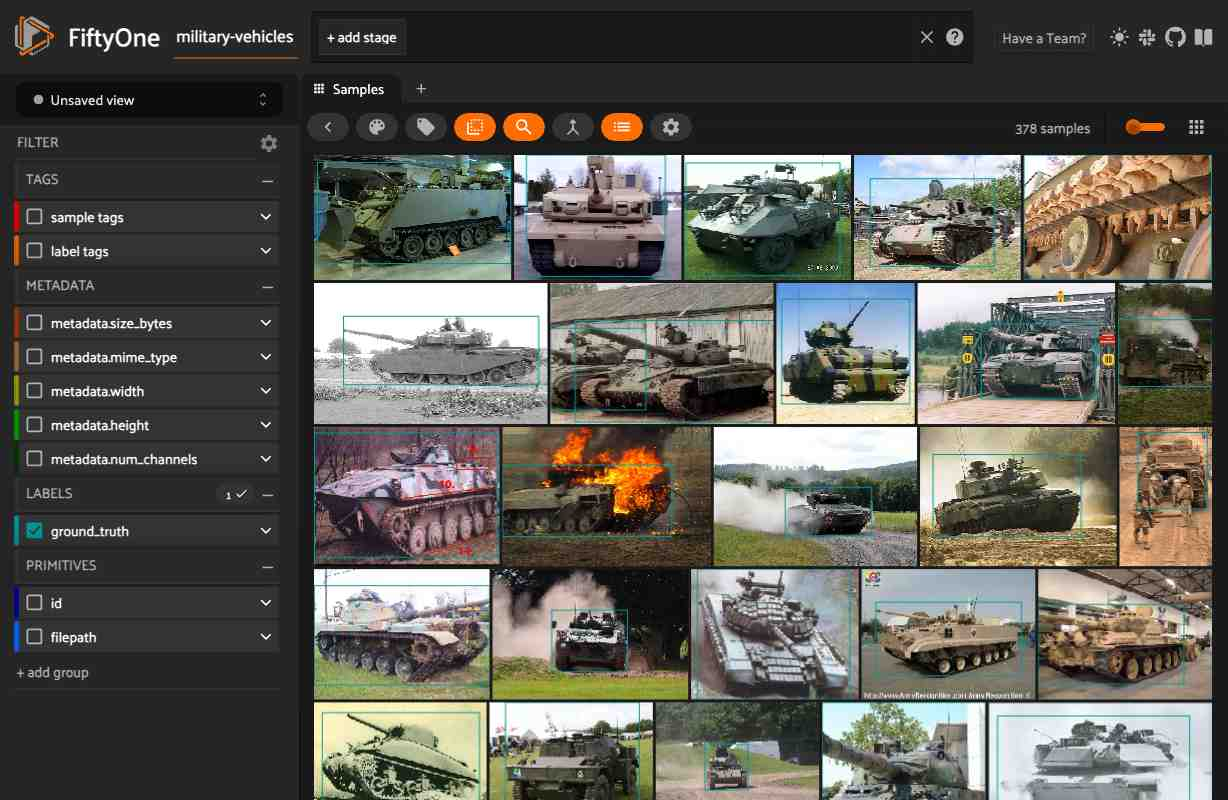

In [13]:
session = fo.launch_app(dataset)

In [14]:
session.freeze()

### Add OpenImage samples

We’ll load Open Images samples with `Tank` detection labels, passing in `only_matching=True` to only load the `Tank` labels. We then map these labels by changing `Tank` into `tank`.

In [15]:
import fiftyone.zoo as foz

oi_samples = foz.load_zoo_dataset(
    "open-images-v7",
    classes = ["Tank"],
    only_matching=True,
    label_types="detections"
).map_labels(
    "ground_truth",
    {"Tank":"tank"}
)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/Users/jonas/fiftyone/open-images-v7/train' if necessary
Necessary images already downloaded
INFO:fiftyone.utils.openimages:Necessary images already downloaded
Existing download of split 'train' is sufficient
INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient
INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/Users/jonas/fiftyone/open-images-v7/test' if necessary
Necessary images already downloaded
INFO:fiftyone.utils.openimages:Necessary images already downloaded
Existing download of split 'test' is sufficient
INFO:fiftyone.zoo.datasets:Existing download of split 'test' is sufficient
INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/Users/jonas/fiftyone/open-images-v7/validation' if necessary
Necessary images already downloaded
INFO:fiftyone.utils.openimages:Necessary images already downloaded
Existing download of split 'validation' is sufficient
INFO:fiftyone.zoo.datasets:Existing dow

We can add these new samples into our training dataset with `merge_samples()`:

In [16]:
dataset.merge_samples(oi_samples)


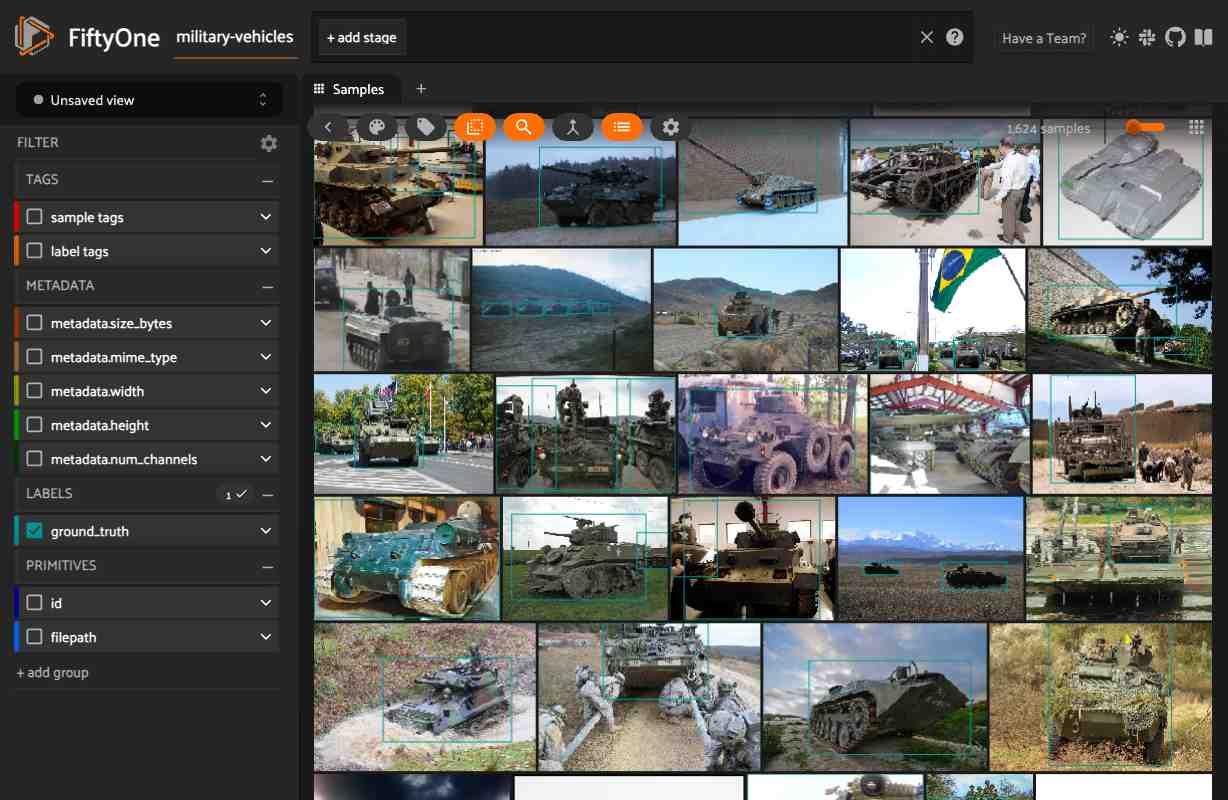

In [17]:
session = fo.launch_app(dataset)

In [18]:
session.freeze()